# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [47]:
#Name
ModelName = 'hr_analytics'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

CAT = ['department'
,'region'
,'education'
,'gender'
,'recruitment_channel'
,'kpis_met_80']

#float
#Testar as variaveis no_of_trainings e previous_year_rating como categorcias e ver se melhora o modelo
NUM = ['no_of_trainings'
,'previous_year_rating'       
,'age'
,'length_of_service'
,'avg_training_score'
]
selected_features = CAT + NUM

# 2. Import Libraries

In [48]:
# !pip -q install -r requirements.txt

In [49]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import altair as alt
import glob
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [50]:
dataprep_df_full = pd.read_csv('./HR_Analytics/dataprep_df.csv')

In [51]:
dataprep_df_full

,department,region,education,gender,recruitment_channel,kpis_met_80,no_of_trainings,previous_year_rating,age,length_of_service,...,dummy_education_Missing,dummy_gender_m,dummy_recruitment_channel_referred,dummy_recruitment_channel_sourcing,dummy_kpis_met_80_1,normalized_no_of_trainings,normalized_previous_year_rating,normalized_age,normalized_length_of_service,normalized_avg_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,1.0,5.0,35.0,8.0,...,0,0,0,1,1,0.000000,1.0,0.375,0.194444,0.166667
1,Operations,region_22,Bachelor's,m,other,0,1.0,5.0,30.0,4.0,...,0,1,0,0,0,0.000000,1.0,0.250,0.083333,0.350000
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,0,1.0,3.0,34.0,7.0,...,0,1,0,1,0,0.000000,0.6,0.350,0.166667,0.183333
3,Sales & Marketing,region_23,Bachelor's,m,other,0,2.0,1.0,39.0,10.0,...,0,1,0,0,0,0.333333,0.2,0.475,0.250000,0.183333
4,Technology,region_26,Bachelor's,m,other,0,1.0,3.0,45.0,2.0,...,0,1,0,0,0,0.000000,0.6,0.625,0.027778,0.566667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54604,Technology,region_14,Bachelor's,m,sourcing,0,1.0,3.0,48.0,17.0,...,0,1,0,1,0,0.000000,0.6,0.700,0.444444,0.650000
54605,Operations,region_27,Master's & above,f,other,0,1.0,2.0,37.0,6.0,...,0,0,0,0,0,0.000000,0.4,0.425,0.138889,0.283333
54606,Analytics,region_1,Bachelor's,m,other,1,1.0,5.0,27.0,3.0,...,0,1,0,0,1,0.000000,1.0,0.175,0.055556,0.666667
54607,Sales & Marketing,region_9,Missing,m,sourcing,0,1.0,1.0,29.0,2.0,...,1,1,0,1,0,0.000000,0.2,0.225,0.027778,0.100000


In [52]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [53]:
#List all dummies and normalized variables
normalized_and_dummy = []
for i in dataprep_df.columns:
    if (i.startswith('dummy_')) or (i.startswith('normalized_')):
        normalized_and_dummy.append(i)
# normalized_and_dummy

In [54]:
#Numeric features must be float type
for col_name in (NUM + normalized_and_dummy):
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

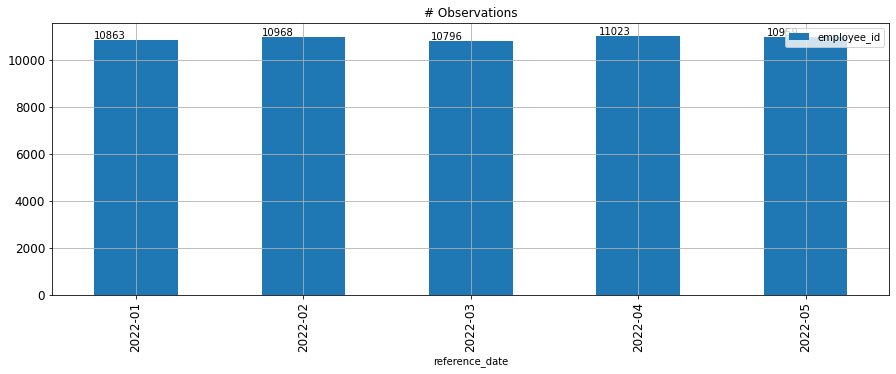

In [55]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId]].groupby(VarDate).agg({VarId:'count'})
ax = dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations"))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## 3.1 Treatment of Numeric Missing Data

In [10]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [11]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [12]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

## Number of Clusters

In [13]:
from sklearn.cluster import KMeans
km_scores= []
for i in range(2, dataprep_df[normalized_and_dummy].shape[1]):
    km = KMeans(n_clusters=i, random_state=1).fit(dataprep_df[normalized_and_dummy])
    km_scores.append(km.inertia_)

In [56]:
df_plot = pd.DataFrame({'number_of_clusters':[i for i in range(2,dataprep_df[normalized_and_dummy].shape[1])],'inertia': km_scores})

In [57]:
df_plot['lag_inertia'] = df_plot['inertia'].shift(1)
df_plot['pct_error_reduction'] = 1-(df_plot['inertia'] / df_plot['lag_inertia'])
# df_plot

In [61]:
max_number_of_clusters = df_plot.query('pct_error_reduction < 0.04')['number_of_clusters'].min()
max_number_of_clusters

6

In [62]:
elbow = alt.Chart(df_plot).mark_line(point=True).encode(
    x=alt.X('number_of_clusters:N', axis=alt.Axis(labelAngle=0)),
    y=alt.Y('inertia'),
    tooltip=[alt.Tooltip('inertia', format='.2f')]
).properties(
    title='Inertia for number of cluster'
).properties(
    title='The elbow method'    
)

v_line = alt.Chart(pd.DataFrame({'max_number_of_clusters' : [max_number_of_clusters]})).mark_rule(color='red').encode(
    x='max_number_of_clusters:N'
)

(elbow + v_line).properties(width=800)

alt.LayerChart(...)

# 4. Modeling

## 4.1 Traning Models with H2O AutoML

## 4.1.1 Creating context and H2O and Importing data into the H2O context

In [63]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 mins 17 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,5 months and 27 days !!!
H2O_cluster_name:,H2O_from_python_maxde_8z3o7y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.112 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [64]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.loc[:, (selected_features + normalized_and_dummy)])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in (NUM + normalized_and_dummy):
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 49056
Validation: 5553


## 4.2.2 Train the H2O Champion algorithm with new data

In [66]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='H2O_KMeans_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators import H2OKMeansEstimator
kmeans = H2OKMeansEstimator(k=max_number_of_clusters,
                             estimate_k=False,
                             standardize=False,
                             seed=1,
                             init='PlusPlus')

# The use of a validation_frame is recommended
kmeans.train(x=normalized_and_dummy,
             training_frame=train_hdf,
             validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(kmeans)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:06.105973

Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1669166229238_3


Model Summary: 


,,number_of_rows,number_of_clusters,number_of_categorical_columns,number_of_iterations,within_cluster_sum_of_squares,total_sum_of_squares,between_cluster_sum_of_squares
0,,49056.0,6.0,0.0,10.0,105068.354763,137789.200929,32720.846166




ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 104859.13769169236
Total Sum of Square Error to Grand Mean: 137789.2009344253
Between Cluster Sum of Square Error: 32930.063242732926

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,6944.0,12853.599830
1,,2.0,6415.0,13291.257538
2,,3.0,7130.0,16529.407455
3,,4.0,11965.0,27839.501073
4,,5.0,8576.0,20073.729402
5,,6.0,8026.0,14271.642393



ModelMetricsClustering: kmeans
** Reported on validation data. **

Total Within Cluster Sum of Square Error: 11846.56885092444
Total Sum of Square Error to Grand Mean: 15560.515357859831
Between Cluster Sum of Square Error: 3713.946506935392

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,888.0,1642.691063
1,,2.0,706.0,1457.379668
2,,3.0,787.0,1808.987839
3,,4.0,1372.0,3180.835711
4,,5.0,924.0,2177.373684
5,,6.0,876.0,1579.300886



Scoring History: 


,,timestamp,duration,iterations,number_of_reassigned_observations,within_cluster_sum_of_squares
0,,2022-11-22 22:22:15,0.031 sec,0.0,NaN,NaN
1,,2022-11-22 22:22:15,0.339 sec,1.0,49056.0,180300.752461
2,,2022-11-22 22:22:15,0.386 sec,2.0,10021.0,112688.684822
3,,2022-11-22 22:22:15,0.511 sec,3.0,4664.0,109645.323416
4,,2022-11-22 22:22:15,0.542 sec,4.0,2738.0,108520.549613
5,,2022-11-22 22:22:15,0.573 sec,5.0,1697.0,107951.869407
6,,2022-11-22 22:22:15,0.589 sec,6.0,1381.0,107676.303578
7,,2022-11-22 22:22:16,0.620 sec,7.0,2305.0,107254.177234
8,,2022-11-22 22:22:16,0.651 sec,8.0,2135.0,106142.957933
9,,2022-11-22 22:22:16,0.682 sec,9.0,1214.0,105347.357383


In [67]:
perf = kmeans.model_performance()
perf


ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 104859.13769169236
Total Sum of Square Error to Grand Mean: 137789.2009344253
Between Cluster Sum of Square Error: 32930.063242732926

Centroid Statistics: 


,,centroid,size,within_cluster_sum_of_squares
0,,1.0,6944.0,12853.599830
1,,2.0,6415.0,13291.257538
2,,3.0,7130.0,16529.407455
3,,4.0,11965.0,27839.501073
4,,5.0,8576.0,20073.729402
5,,6.0,8026.0,14271.642393


In [68]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

In [69]:
h2o.save_model(model=kmeans, path='%s/models/candidates/' % OutputPath, force=True)

'D:\\OneDrive\\FIEP\\FIEP-Machine-Learning-e-Computacao-em-Nuvem\\clusters_segmentation\\output_model\\models\\candidates\\KMeans_model_python_1669166229238_3'

# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [70]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, kmeans.model_id))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    print(e)

path_model_mojo: D:\OneDrive\FIEP\FIEP-Machine-Learning-e-Computacao-em-Nuvem\clusters_segmentation\output_model\models\best\KMeans_model_python_1669166229238_3.zip


In [71]:
#Confusion Matrix for the Champion
df_cluster_tmp = h2o.mojo_predict_pandas(dataprep_df.loc[:, (normalized_and_dummy)], mojo_zip_path=path_model_mojo, verbose=False)

df_cluster = pd.concat([df_cluster_tmp.reset_index(drop=True), dataprep_df.loc[:, (normalized_and_dummy+selected_features)].reset_index(drop=True)], axis=1)
# df_cluster['cluster'] = df_cluster['cluster'] + 1
df_cluster['cluster'] = df_cluster['cluster'].astype(int)

df_cluster

,cluster,dummy_department_Finance,dummy_department_HR,dummy_department_Legal,dummy_department_Operations,dummy_department_Procurement,dummy_department_R&D,dummy_department_Sales & Marketing,dummy_department_Technology,dummy_region_region_10,...,region,education,gender,recruitment_channel,kpis_met_80,no_of_trainings,previous_year_rating,age,length_of_service,avg_training_score
0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,region_7,Master's & above,f,sourcing,1,1.0,5.0,35.0,8.0,49.0
1,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,region_22,Bachelor's,m,other,0,1.0,5.0,30.0,4.0,60.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,region_19,Bachelor's,m,sourcing,0,1.0,3.0,34.0,7.0,50.0
3,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,region_23,Bachelor's,m,other,0,2.0,1.0,39.0,10.0,50.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,region_26,Bachelor's,m,other,0,1.0,3.0,45.0,2.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54604,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,region_14,Bachelor's,m,sourcing,0,1.0,3.0,48.0,17.0,78.0
54605,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,region_27,Master's & above,f,other,0,1.0,2.0,37.0,6.0,56.0
54606,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,region_1,Bachelor's,m,other,1,1.0,5.0,27.0,3.0,79.0
54607,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,region_9,Missing,m,sourcing,0,1.0,1.0,29.0,2.0,45.0


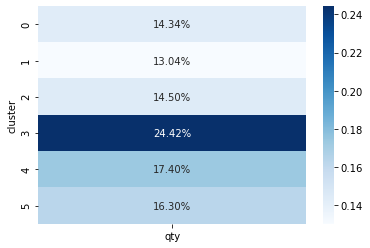

In [72]:
df_cluster_plot = df_cluster.reset_index().groupby(['cluster']).count()[['index']].rename(columns={'index': 'qty'})
# sns.heatmap(df_cluster_plot, annot=True, center=True,cmap='Blues', fmt='g')
# plt.show()
sns.heatmap(df_cluster_plot/np.sum(df_cluster_plot), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 6. Save final dataset with predictions to CSV to explain the model

In [73]:
df_cluster.to_csv('./HR_Analytics/df_cluster.csv', index=False, header=True)